In [1]:
import numpy as np
import cv2 as cv
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm

In [155]:
img_path = '../leftImg8bit_trainvaltest/leftImg8bit/train/strasbourg'
filenames = [img for img in glob.glob(img_path + "/*.png")]
filenames.sort()

In [156]:
images = []
for fname in filenames:
    img = cv.imread(fname)
    images.append(img)

In [157]:
len(images)

365

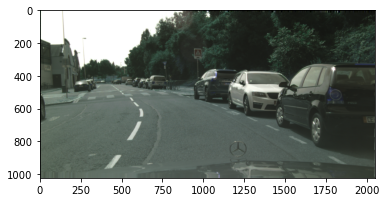

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 457/457 [00:00<00:00, 554.03it/s]


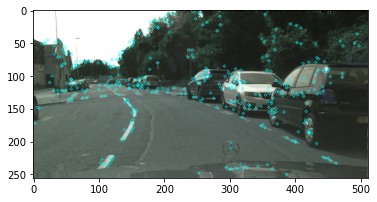

In [158]:
img = images[0]
plt.imshow(img)
plt.show()

def draw_keypoints(vis, keypoints, color = (0, 255, 255)):
    for i in tqdm(range(len(keypoints))):
        kp = keypoints[i]
        x, y = kp.pt
        plt.imshow(cv.circle(vis, (int(x), int(y)), 2, color))

img = cv.resize(img, (512, 256))
sift = cv.SIFT_create()
kp, des = sift.detectAndCompute(img, None)
img = draw_keypoints(img, kp)

In [163]:
detector = cv.SIFT_create()
unclustered = np.zeros((0, 128), dtype=np.float32)

for img in images[:90]:
    img = cv.resize(img, (512, 256))
    kp = detector.detect(img, None)
    kp, des = sift.compute(img, kp)
    unclustered = np.vstack((unclustered, des))

In [164]:
dict_size = 200
tc = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.001)
retries = 1
flags = cv.KMEANS_PP_CENTERS

bow_trainer = cv.BOWKMeansTrainer(dict_size, tc, retries, flags)
dictionary = bow_trainer.cluster(unclustered)

In [165]:
dictionary.shape

(200, 128)

In [166]:
matcher = cv.FlannBasedMatcher()
detect = cv.SIFT_create()
extract = cv.SIFT_create()
bow_extract = cv.BOWImgDescriptorExtractor(extract, matcher)
bow_extract.setVocabulary(dictionary)

In [167]:
bowvecs = list()

for img in images:
    img = cv.resize(img, (512, 256))
    kp = detector.detect(img, None)
    bowvec = bow_extract.compute(img, kp)
    bowvecs.append(bowvec)

In [176]:
from scipy.spatial.distance import cosine as cos_sim

closures = list()
for i in range(len(bowvecs)):
    for j in range(i+1, len(bowvecs)):
        score = cos_sim(bowvecs[i], bowvecs[j])
        if i != j and score < 0.13:
            closures.append((i, j))
            print(str(i) + ", " + str(j) + ": " + str(score))

23, 57: 0.10359495878219604
55, 56: 0.11921721696853638
105, 106: 0.12206459045410156
106, 144: 0.1249995231628418
109, 110: 0.11799460649490356
109, 111: 0.1287044882774353
110, 111: 0.11968457698822021
141, 142: 0.10828995704650879
179, 223: 0.12444299459457397


In [177]:
len(closures)

9

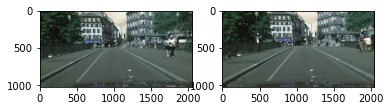

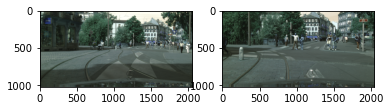

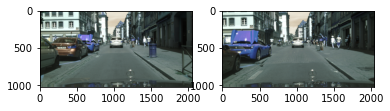

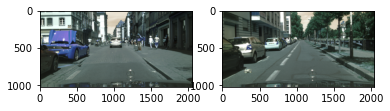

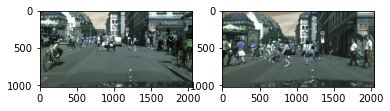

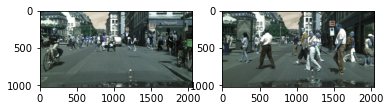

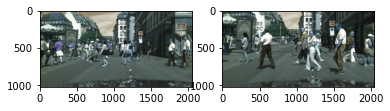

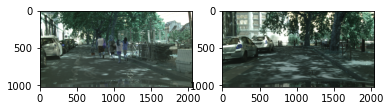

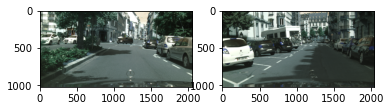

In [185]:


for i, j in closures:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(images[i])
    ax2.imshow(images[j])


# i, j = closures[0]
# img1 = images[i]
# img2 = images[j]

# plt.imshow(img1)
# plt.show()
# plt.imshow(img2)
# plt.show()

In [154]:
len(bowvecs)**2

14884

In [202]:
cap = cv.VideoCapture('../NewCollege.avi')

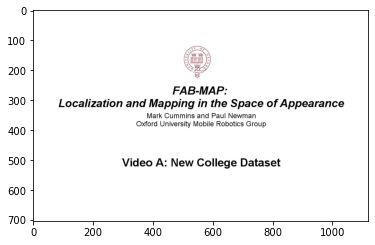

In [230]:
for idx, (i, j) in enumerate(closures):
    img1 = images[i]
    img2 = images[j]
    
    cv.imwrite("img%d-%d.jpg" % (idx, 1), img1)
    cv.imwrite("img%d-%d.jpg" % (idx, 2), img2)